In [33]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from tqdm import tqdm
import medpy.metric as metric

import torch
import torch.nn as nn
import wandb

import monai
from monai.data import DataLoader, Dataset
from monai.transforms.utils import allow_missing_keys_mode
from monai.transforms import BatchInverseTransform
from monai.networks.nets import DynUNet

In [195]:
device = "cpu"
seed = 0

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
monai.utils.misc.set_determinism(seed, use_deterministic_algorithms=True)
torch.use_deterministic_algorithms(True)

In [99]:
def count_parameters(model): 
    """ Get the number of params in a model. See: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = DynUNet(
    spatial_dims = 2,   # 2 for 2D convolutions, 3 for 3D convolutions
    in_channels  = 1,   # Number of input channels/modalities (3 for RGB)
    out_channels = 4,   # Number of classes, including background
    kernel_size  = [3, 3, 3, 3, 3, 3], # Size of the filters
    strides      = [1, 2, 2, 2, 2, 2],
    upsample_kernel_size = [2, 2, 2, 2, 2]
).to(device)

print(f"Num params: {count_parameters(model):_}")

Num params: 20_611_236


## Get the layers of the model

In [100]:
print(model)

DynUNet(
  (input_block): UnetBasicBlock(
    (conv1): Convolution(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (conv2): Convolution(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    (norm1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (norm2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  )
  (downsamples): ModuleList(
    (0): UnetBasicBlock(
      (conv1): Convolution(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (conv2): Convolution(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
      (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [110]:
for i, mod in enumerate(model.modules()):
    if isinstance(mod, nn.Conv2d):
        weights = mod.weight.data.numpy()
        
        # print([p.shape for p in mod.parameters()])

torch.Size([32, 1, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([256, 128, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([512, 256, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 1024, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([256, 512, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([128, 256, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([64, 128, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([32, 64, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([4, 32, 1, 1])


In [70]:
print(model.modules())

<generator object Module.modules at 0x7f98659f2ce0>


In [40]:
for a in model.parameters():
    print(a)
    break

Parameter containing:
tensor([[[[ 0.7128,  0.6357, -0.2089],
          [ 0.3018, -0.1598,  0.0665],
          [-0.3215,  0.6422,  0.2165]]],


        [[[ 0.4400,  0.7016,  0.1574],
          [-0.4288, -0.1034, -0.7569],
          [-0.1782,  0.0519, -0.4763]]],


        [[[ 0.4617,  0.2051, -0.5774],
          [-0.2657, -0.3321,  0.6705],
          [-0.1142,  0.5350, -0.3857]]],


        [[[-0.0248, -0.6101,  0.1482],
          [ 0.8123, -0.3209, -0.4485],
          [-0.0945,  0.3384, -0.7520]]],


        [[[-0.3663, -0.0685,  0.2724],
          [ 0.0839,  0.1224,  0.2337],
          [-0.4058, -0.3821,  0.4794]]],


        [[[-0.3895, -0.0104,  0.5181],
          [-0.1106,  0.0044,  0.0432],
          [-0.5318, -0.2960,  0.6679]]],


        [[[-0.3758, -0.9848,  0.9800],
          [ 0.2404,  1.2224,  0.0541],
          [-0.5593, -0.9484, -0.1117]]],


        [[[ 0.1079,  0.1908, -0.3200],
          [-0.2266,  0.9132,  0.7413],
          [ 0.1029,  0.3453, -0.3131]]],


        [[

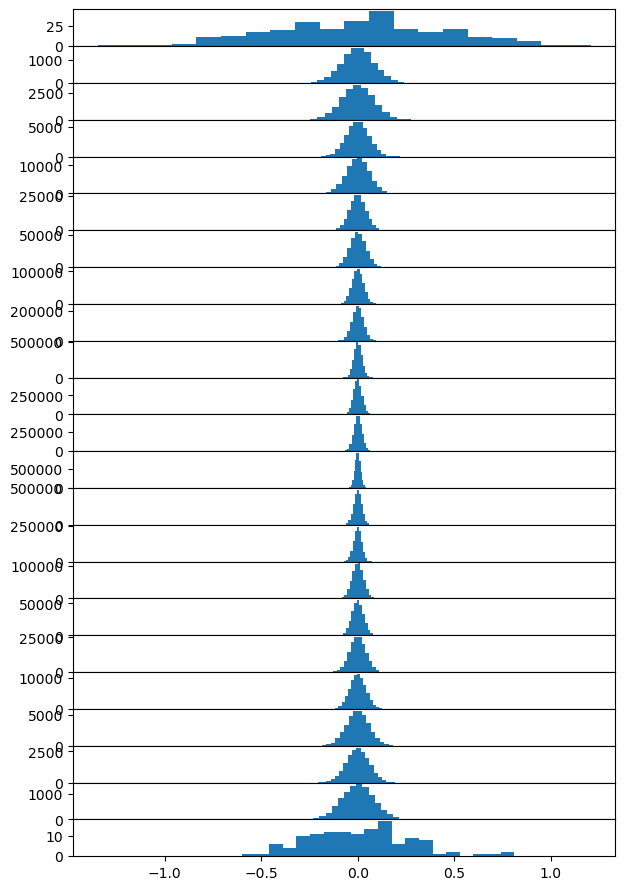

In [151]:
n_modules = 23
fig, axs = plt.subplots(n_modules, 1, figsize=(7, n_modules // 2), sharex=True)
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

n = 0
for mod in model.modules():
    if isinstance(mod, nn.Conv2d):
        weights = mod.weight.data.cpu().numpy().flatten()
        axs[n].hist(weights, bins=20)
        n += 1
    if n == n_modules:
        break

plt.show()
